# Decomposition And Embedding

## Purpose
The purpose of this step is to run PCA and manifold leanring (tSNE and UMAP) on the cell-by-feature matrix, feature to use can be either HVF or CEF. We use both the mCH and mCG matrix. We first run PCA on mCH and mCG matrix separately, and then concatenate mCH and mCG top PCs together to run KNN, followed by tSNE and UMAP embedding.

## Input
- HVF adata files.

## Output
- HVF adata file with PCA, tSNE and UMAP calculated.

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

from ALLCools.clustering import tsne, balanced_pca, significant_pc_test, log_scale
from ALLCools.plot import *

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [3]:
# cell metadata path
metadata_path = 'CellMetadata.PassQC.csv.gz'

# HVF mC Fraction AnnData Files
ch_adata_path = 'mCH.HVF.h5ad'
cg_adata_path = 'mCG.HVF.h5ad'

# use feature type
# HVF: all highly variable features
# CEF: cluster enriched features
feature_type = 'CEF' 
pre_cluster_name = 'leiden'

# n_components
n_components = 'auto'  # if auto, will use Kolmogorov-Smirnov test to test the adjacent PCs and cut when P > p_cutoff
p_cutoff = 0.1  # ks test p value cutoff, only apply when n_components == 'auto'

# downsample large clusters
max_cell_prop = 0.05

## Load Data

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)

In [5]:
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

In [6]:
if feature_type == 'CEF':
    print('Using Cluster Enriched Features')
    ch_adata = ch_adata[:, ch_adata.var[f'{pre_cluster_name}_enriched_features']].copy()
    cg_adata = cg_adata[:, cg_adata.var[f'{pre_cluster_name}_enriched_features']].copy()

Using Cluster Enriched Features


## Scale

In [7]:
ch_scaler = log_scale(ch_adata)

cg_scaler = log_scale(cg_adata)

## PCA - mCH

### Run PCA

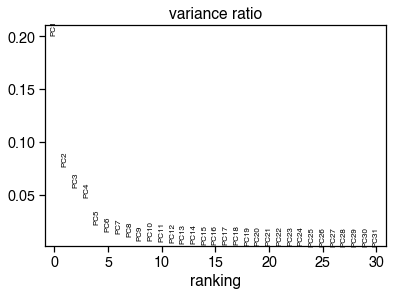

40 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 200) to (16985, 40)


In [8]:
balanced_pca(ch_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(ch_adata)
ch_n_components = significant_pc_test(ch_adata, p_cutoff=p_cutoff)

### Plot

Red axis labels are used PCs


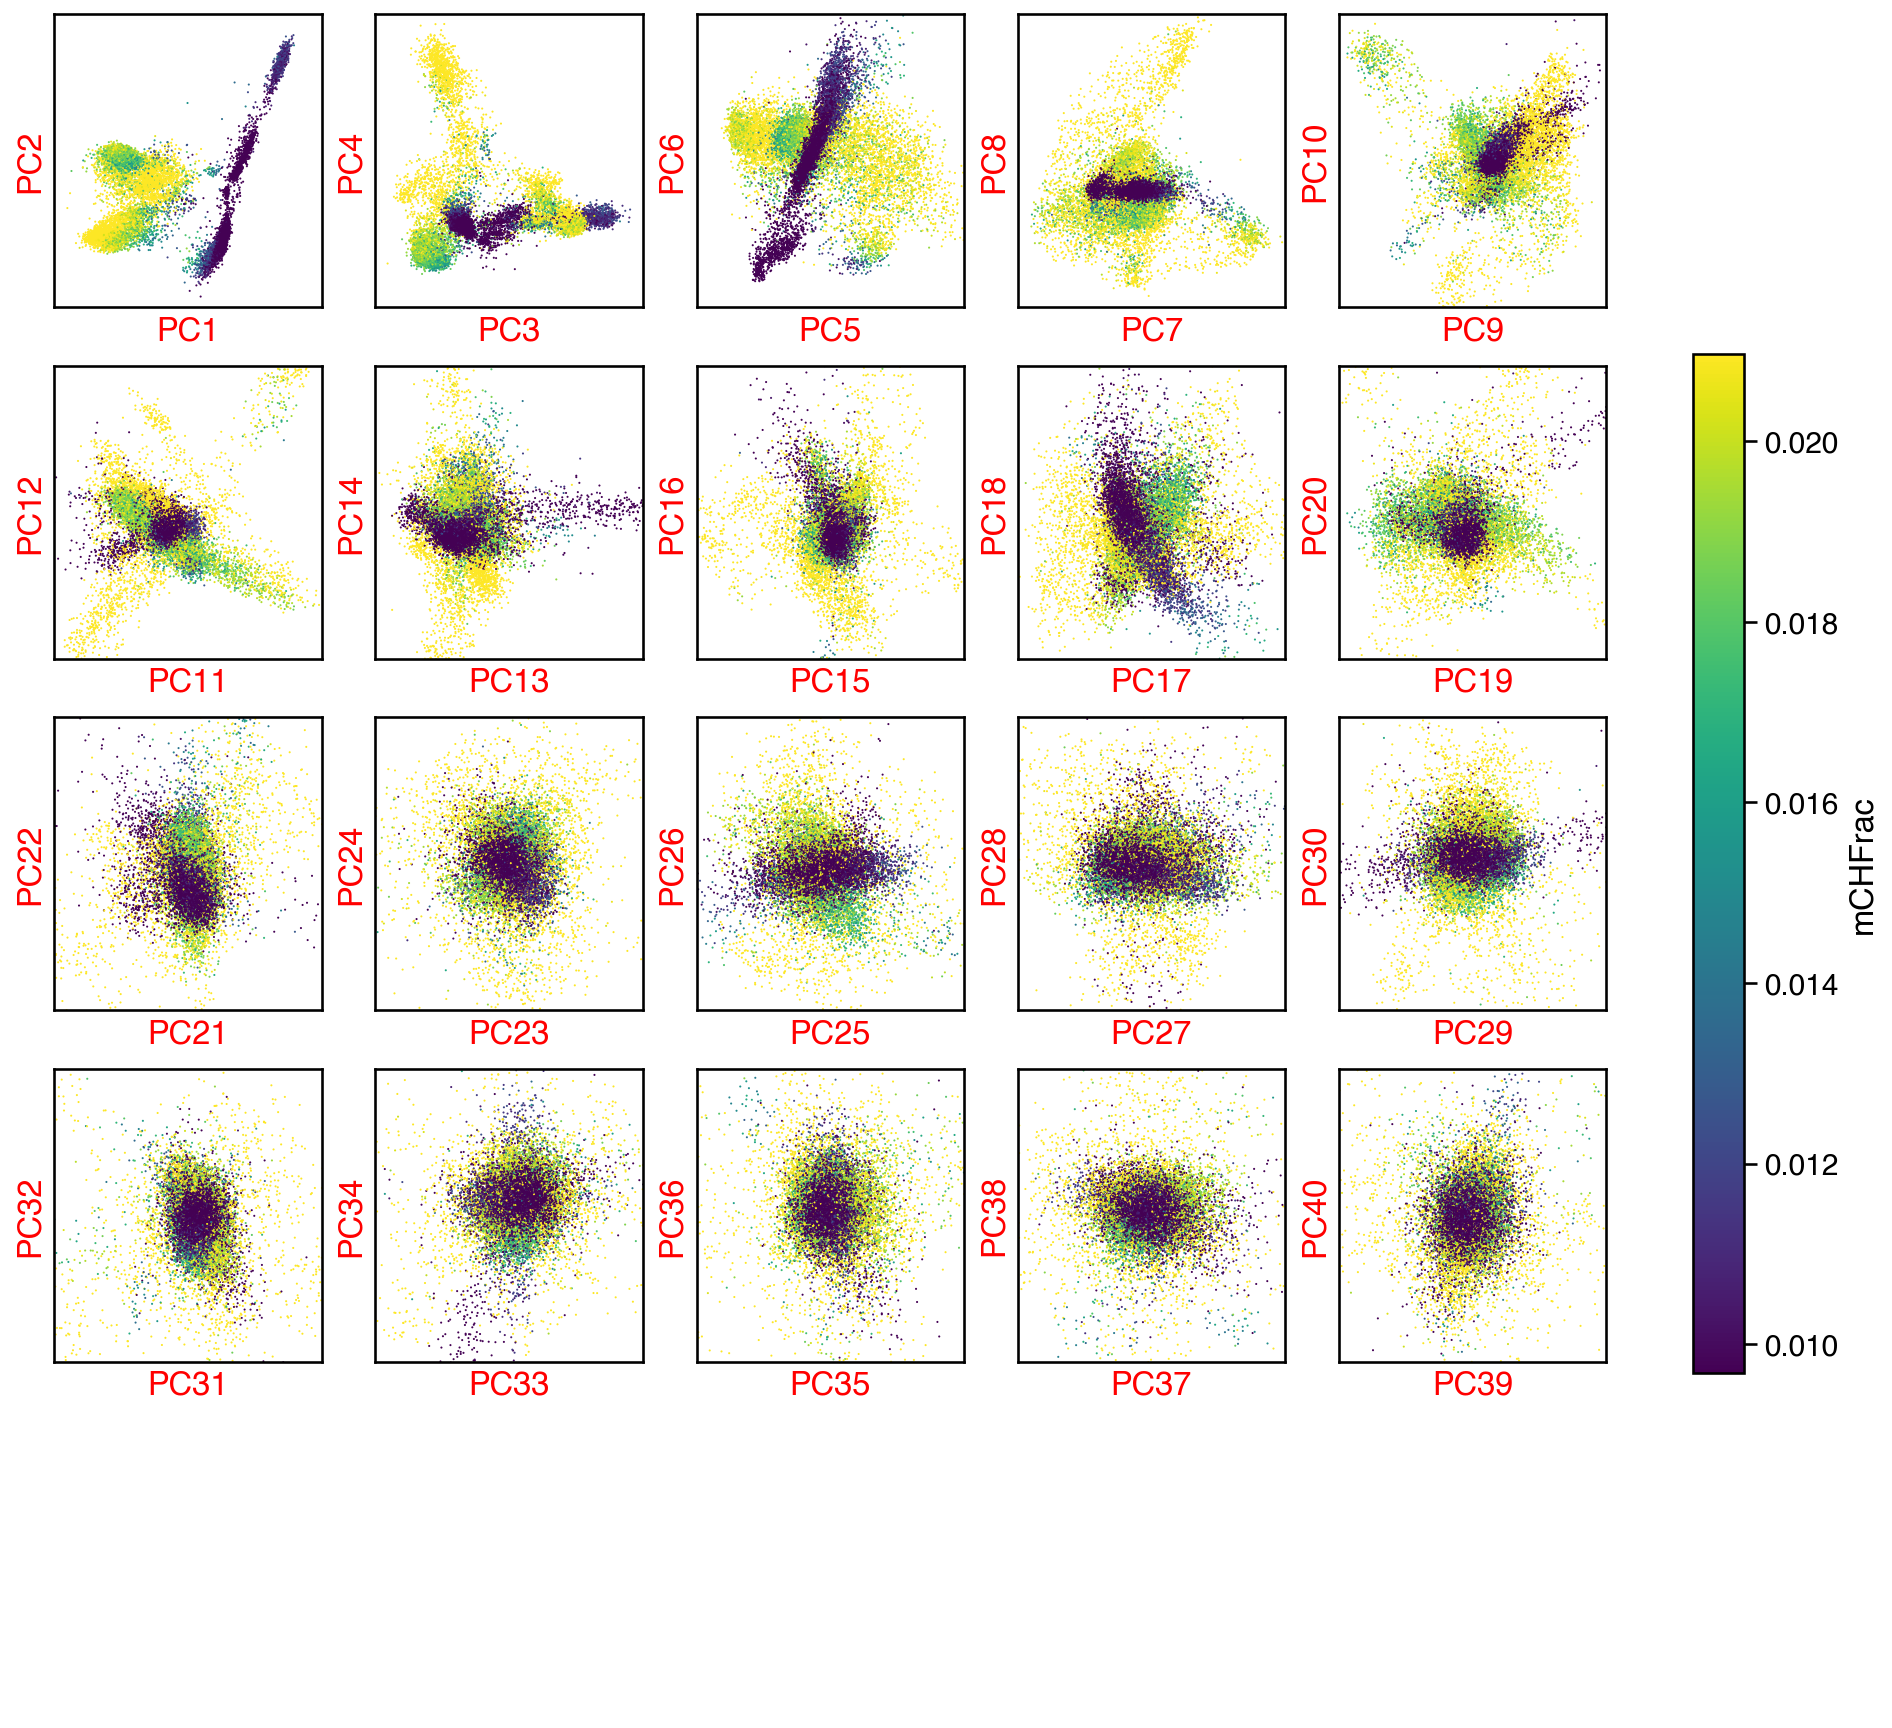

In [9]:
hue = 'mCHFrac'
if hue in metadata.columns:
    ch_adata.obs[hue] = metadata[hue].reindex(ch_adata.obs_names)
    fig, axes = plot_decomp_scatters(ch_adata,
                                     n_components=ch_n_components,
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

## PCA - mCG

### Run PCA

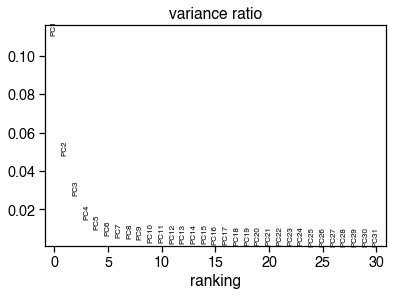

43 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 200) to (16985, 43)


In [10]:
balanced_pca(cg_adata, groups=pre_cluster_name)
sc.pl.pca_variance_ratio(cg_adata)
cg_n_components = significant_pc_test(cg_adata, p_cutoff=p_cutoff)

### Plot

Red axis labels are used PCs


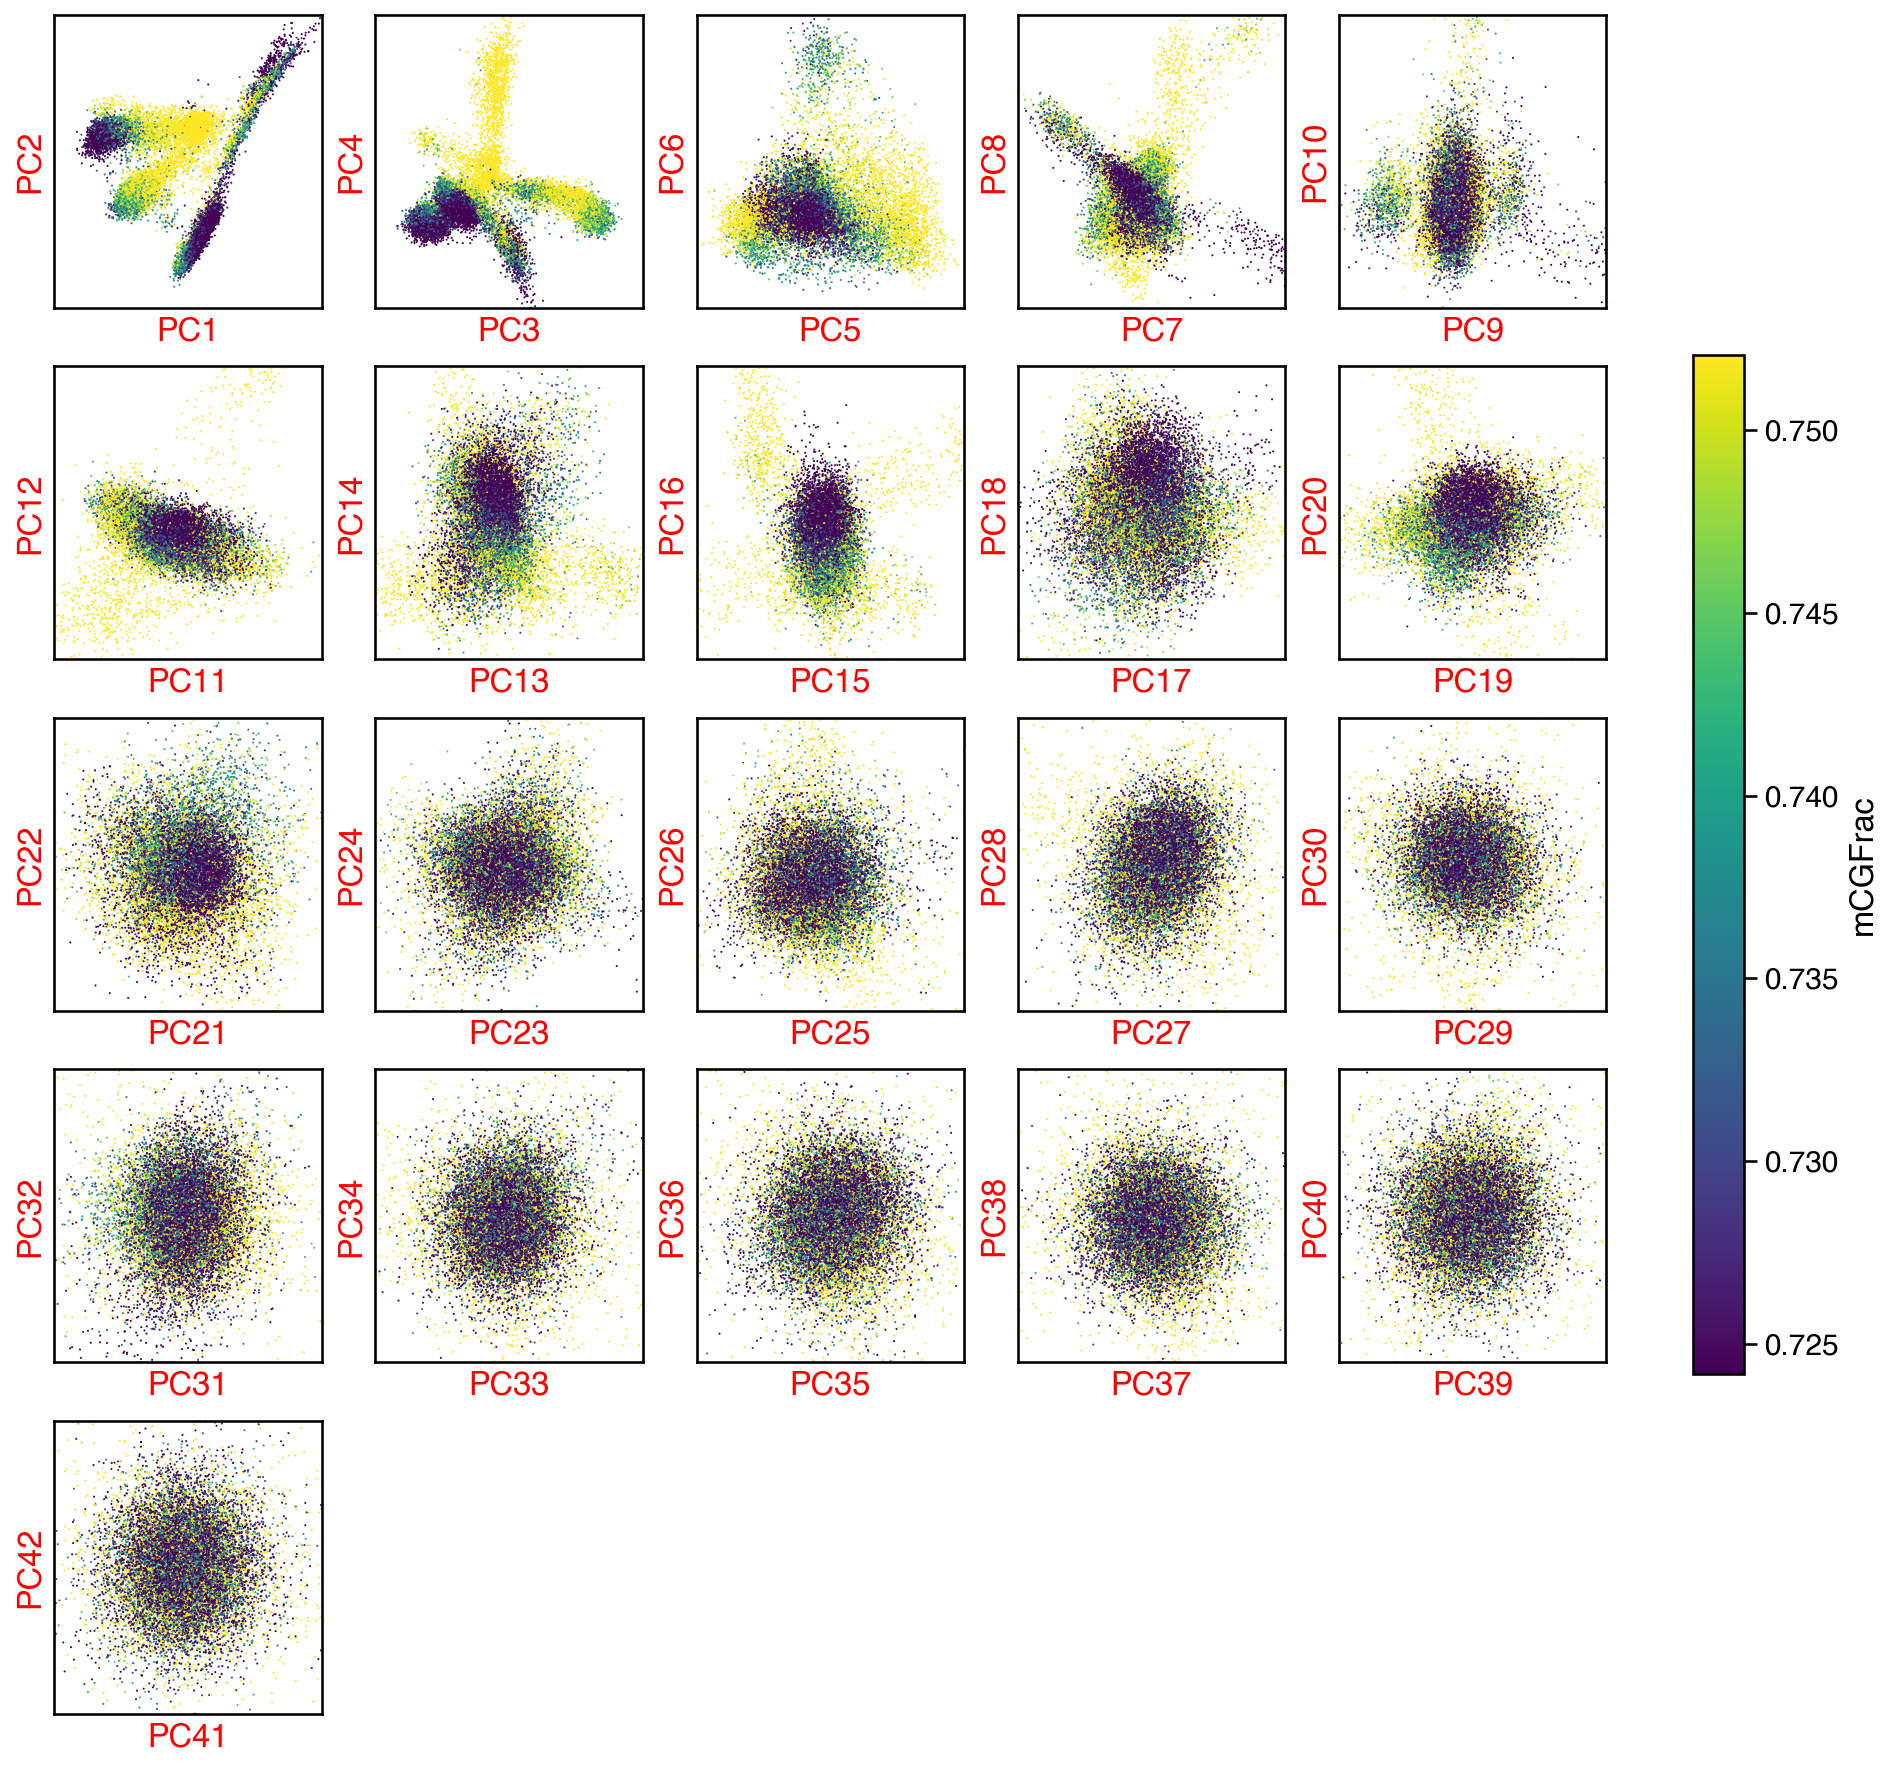

In [11]:
hue = 'mCGFrac'
if hue in metadata.columns:
    cg_adata.obs[hue] = metadata[hue].reindex(cg_adata.obs_names)
    fig, axes = plot_decomp_scatters(cg_adata,
                                     n_components=cg_n_components,
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

## Combined PCs

In [12]:
ch_pcs = ch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = cg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

In [13]:
# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = ch_adata.copy()

In [14]:
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

## Manifold Learning

In [15]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

### tSNE

In [16]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(adata, 'tsne')

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'L1', 'mCHFrac', 'tsne_0', 'tsne_1'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'L1_enriched_features'
    uns: 'L1_feature_enrichment', 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'neighbors', 'umap', 'log'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

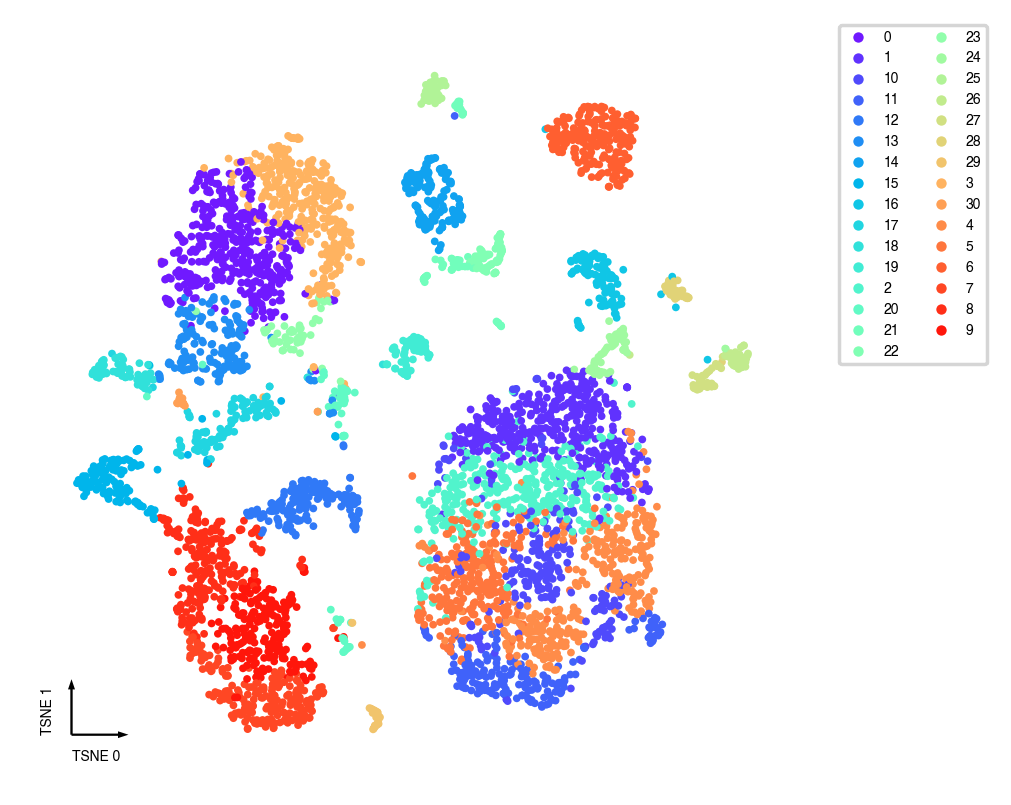

In [17]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='tsne', hue=pre_cluster_name, show_legend=True)

### UMAP

In [18]:
sc.pp.neighbors(adata)
try:
    sc.tl.paga(adata, groups=pre_cluster_name)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
except:
    sc.tl.umap(adata)
dump_embedding(adata, 'umap')

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'L1', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'L1_enriched_features'
    uns: 'L1_feature_enrichment', 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'neighbors', 'umap', 'log', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

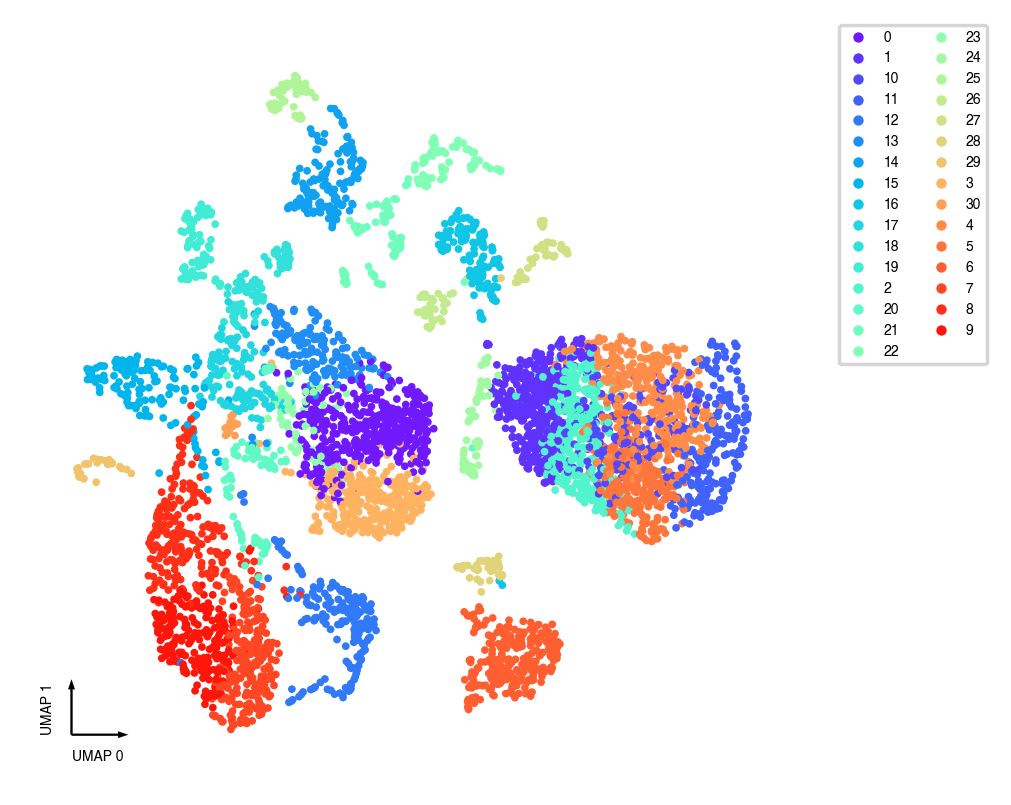

In [19]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs, ax=ax, coord_base='umap', hue=pre_cluster_name, show_legend=True)

### Interactive Scatter

In [20]:
# in order to reduce the page size, I downsample the data here, you don't need to do this
interactive_scatter(data=adata.obs.sample(2500),
                    hue=pre_cluster_name,
                    coord_base='umap')

## Save Results

In [21]:
adata.write_h5ad(f'adata.with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'L1', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'L1_enriched_features'
    uns: 'L1_feature_enrichment', 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'neighbors', 'umap', 'log', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

## Save Reproducible PCA (if needed)


### ReproduciblePCA
This class can save the selected features, scaler loadings and PC loadings into one object. 
The saved object can transform a new MCDS object from raw counts all the way to adata with PCs, allowing quick preprocessing to prepare input for the downstream prediction, integration and clustering analysis.

In [22]:
from ALLCools.clustering import ReproduciblePCA

ch_rpca = ReproduciblePCA(scaler=ch_scaler, mc_type='CHN', adata=ch_adata)
ch_rpca.dump('CHN.ReproduciblePCA.lib')

cg_rpca = ReproduciblePCA(scaler=cg_scaler, mc_type='CHN', adata=cg_adata)
cg_rpca.dump('CGN.ReproduciblePCA.lib')

### how to use ReproduciblePCA to quickly transfer MCDS into adata with PCs

```python
import joblib
from ALLCools.mcds import MCDS

mcds = MCDS.open(mcds_paths)
rpca = joblib.load('ReproduciblePCA.lib')
adata = rpca.mcds_to_adata_with_pc(mcds)
# adata will have the same var selected and PC space.
```